<div><img width="120px" style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación de dígitos con redes convolucionales<a id="top"></a>

<i><small>Autores: Alberto Díaz Álvarez y Guillermo Iglesias Hernández<br>Última actualización: 2023-10-05</small></i></div>
                                                  

***

## Introducción

El mundo de la visión por computador ha experimentado una revolución en la última década, particularmente con el resurgimiento y avances en redes neuronales. Las imágenes, al ser datos de alta dimensión y con interdependencias estructurales, presentan desafíos únicos que no se abordan adecuadamente con las técnicas tradicionales de aprendizaje automático. Aquí es donde las Redes Neuronales Convolucionales (CNN) han mostrado su magia, logrando avances sorprendentes en tareas como la clasificación de imágenes, la detección de objetos y la segmentación semántica.

La esencia de las CNNs radica en su capacidad para aprender representaciones jerárquicas y espaciales de datos, especialmente imágenes. Al utilizar operaciones especializadas, como convoluciones y pooling, estas redes pueden capturar patrones locales y globales en imágenes, lo que las hace especialmente potentes para tareas de visión por computadora.

### Objetivos

Los objetivos de esta práctica son:

1. **Comprender las Convoluciones**: Adentrarnos en la operación matemática detrás de las convoluciones y cómo contribuyen a la extracción de características en imágenes.
2. **Implementar Redes Convolucionales en Keras**: Keras, siendo una de las bibliotecas de aprendizaje profundo más populares y fáciles de usar, nos permite construir, entrenar y evaluar CNNs de manera eficiente. Aprenderemos a utilizarla para construir una red que pueda clasificar dígitos escritos a mano.
3. **Comparar con Perceptrones Multicapa**: Aunque ambos son tipos de redes neuronales, las CNNs y los perceptrones multicapa tienen diferencias fundamentales en su arquitectura y aplicabilidad. Compararemos su rendimiento y discutiremos en qué escenarios uno puede ser preferible sobre el otro.

En este notebook, no sólo aprenderemos la teoría detrás de las CNNs, sino que también nos sumergiremos en su implementación práctica, usando el famoso conjunto de datos MNIST como nuestro campo de juego. ¡Comenzamos!

## Bibliotecas y configuración

Comenzaremos instalando las bibliotecas necesarias. Esto sólo es necesario en el caso de que no tengamos el entorno ya creado.

In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow

A continuación importaremos las bibliotecas que se utilizarán a lo largo del notebook.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2023-10-04 01:48:33.988026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 01:48:33.988052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 01:48:33.988068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 01:48:33.992472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 01:48:34.506470: W tensorflow/compiler/

Forzamos algunos parámetros de configuración

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Usar CPU

***

## Convoluciones: Una mirada profunda

Imagina una pequeña ventana que se desliza sobre una imagen. A medida que esta ventana se mueve, realiza un producto punto (_dot product_) entre los valores de la ventana y una matriz de filtro (_kernel_) de tamaño similar. El resultado de este producto punto se coloca en una nueva matriz, creando una versión transformada (a menudo más pequeña) de la imagen original.

| ![Funcionamiento de una convolución](https://miro.medium.com/v2/resize:fit:640/0*dSjXKGG6kJ5kVUgJ) | 
|:--:| 
| **Figura 1**. _Funcionamiento de una convolución_. Fuente: [Icecream Labs @ Medium](https://icecreamlabs.medium.com/3x3-convolution-filters-a-popular-choice-75ab1c8b4da8) |

Las convoluciones, al ser operaciones matemáticas, permiten detectar patrones en las imágenes. Estos patrones pueden ser bordes, texturas o cualquier otro tipo de característica local. Dado un filtro adecuado, la operación de convolución destacará ciertas características y atenuará otras, lo que resulta en la extracción de características importantes para tareas como la clasificación.

Pero, **¿qué es un filtro?** También conocido como _kernel_, es una pequeña matriz que se utiliza para extraer características de una imagen. Dependiendo de los valores dentro de este filtro, se pueden detectar diferentes características. Por ejemplo, ciertos filtros son buenos para detectar bordes verticales, mientras que otros pueden detectar bordes horizontales.

Por ejemplo, un filtro simple que detecta bordes verticales podría verse así:

```
-1  1  0
-1  1  0
-1  1  0
```

Cuando aplicas este filtro a una imagen usando una operación de convolución, los bordes verticales se destacarán en el mapa de características resultante. ¿Cómo que mapa de características? Es como se le llama a la imagen resultante de aplicarle un filtro, es decir, la imagen transformada donde las características que el filtro estaba diseñado para detectar se han destacado.

| ![Imagen original y sus 16 mapas de características asociados, resultado de aplicar 16 filtros diferentes](https://www.bouvet.no/bouvet-deler/understanding-convolutional-neural-networks-part-1/_/attachment/inline/232e3fa0-9c7d-4ed7-ad57-f29839736ba3:600ca41808abf40651360ba7bad043ce3e912563/Screenshot%202019-07-01%20at%2012.22.22.png) | 
|:--:| 
| **Figura 2**. _Imagen original y sus 16 mapas de características asociados, resultado de aplicar 16 filtros diferentes_. Fuente: [Mark West @ Bouvet Oslo](https://www.bouvet.no/bouvet-deler/understanding-convolutional-neural-networks-part-1) |

Su importancia radica en que estos mapas de características **actúan a su vez como entradas para las siguientes capas** en una red neuronal convolucional. A medida que avanzamos en la red los filtros se vuelven más complejos, detectando características de nivel superior (por ejemplo, combinaciones de bordes que forman formas o patrones).

| ![Diferentes filtros para diferentes problemas donde se aprecia su creciente complejidad según se profundiza en la red](https://glassboxmedicine.files.wordpress.com/2020/08/siegel-from-lee-later-layer-filters.png) | 
|:--:| 
| **Figura 3**. _Diferentes filtros para diferentes problemas donde se aprecia su creciente complejidad según se profundiza en la red_. Fuente: [Rachel Draelos @ Glass Box](https://glassboxmedicine.com/2020/08/03/convolutional-neural-networks-cnns-in-5-minutes/) |

Conociendo el concepto de filtro podemos definir las capas de convolución como el conjunto de filtros que actuan sobre una imagen para generar una nueva imagen, ya sea esta imagen la original o la generada por una capa anterior. Cada uno de los filtros generará una nueva imagen que llamamos mapa de características, que se corresponderá con un canal de la nueva imágen. Así, si una capa de convolución posee 16 filtros, la imagen de salida será de 16 canales, uno por cada filtro.

¿Donde está la gracia de esto? En que los filtros no vienen predefinidos, sino que se van aprendiendo en cada epoch. En efecto, al igual que en un perceptrón se aprenden los pesos idóneos para extraer características, en un filtro lo que se aprenden son los valores de cada celda del filtro. Veamos en términos de ahorro. Supongamos que tenemos una imagen de $100 \times 100$; una capa de un perceptrón de $4$ neuronas (muy pocas) contiene $100 \cdot 100 \cdot 4 = 40000$ parámetros a aprender; una capa de convolución de $100$ filtros de $3 \times 3$ contiene $100 \cdot 3 \cdot 3 = 900$ parámetros, independientemente del tamaño de la imagen. Desde luego es un ahorro considerable.

Más cosas. Dentro del mundo de las redes de convolución no sólo existen las capas de convolución, sino que hay otros tipos de capas útiles para determinados contextos. Por ejemplo, ¿qué ocurre cuando las dimensiones de nuestro mapa de características es demasiado grande? Desde luego más computación de la debida. Para ello existen las capas de _pooling_.

Se trata de una técnica que se utiliza para disminuir esstas dimensiones espaciales (ancho y alto). La idea es usar un filtro para seleccionar cierta información de una región y descartar la restante.


| ![Funcionamiento de dos tipos de _pooling_: _max pooling_ y _average pooling_](https://cdn-images-1.medium.com/max/726/1*fXxDBsJ96FKEtMOa9vNgjA.gif) | 
|:--:| 
| **Figura 3**. _Funcionamiento de dos tipos de pooling: max pooling y average pooling_. Fuente: [Saul Dobilas @ Towrds Datascience](https://glassboxmedicine.com/2020/08/03/convolutional-neural-networks-cnns-in-5-minutes/) |

Existen diferentes tipos de _pooling_, siendo los más comunes:

- **Max Pooling**: Selecciona el **valor máximo** de una región del mapa de características.
- **Average Pooling**: Toma el **promedio** de los valores en una región del mapa de características.

Las ventajas que aportan estas capas a una red de convolución se pueden dividir en dos principalmente:

1. **Menor coste computacional**: Al reducir las dimensiones, reducimos la cantidad de parámetros y cálculos necesarios en las capas siguientes.
2. **Invarianza a la traslación**: Al usar pooling, la red se vuelve un poco más robusta a pequeñas variaciones o cambios en la posición de las características dentro de una imagen.

Esto proporciona una visión general y una introducción sólida a las operaciones fundamentales en una red neuronal convolucional. A partir de aquí, continuaremos con una implementación práctica de este tipo de redes sobre un problema que ya conocemos, el de la clasificación de dígitos.

## Funciones auxiliares

Antes de comenzar, haremos uso de la función auxiliar del ejemplo anterior `show_examples`.

In [21]:
def show_examples(X, y=None, ŷ=None):
    fig, ax = plt.subplots(1, 5, figsize=[25, 5])

    for i, img in enumerate(X[:5]):
        title = None
        if y is not None:
            title = f'$y = {y}$'
        if ŷ is not None:
            title += f'\n$ŷ = {np.argmax(ŷ[i])}$'
        if title:
            ax[i].set_title(title)
        cmap = 'gist_gray'
        if y is not None and ŷ is not None and not np.allclose(y, np.argmax(ŷ[i])):
            cmap = 'gist_heat'
        ax[i].imshow(img, cmap=cmap)
    plt.show()

## Preparación del conjunto de datos

Ya conocemos el conjunto de datos MNIST. Ahora procederemos a cargar ambos conjuntos de datos (entrenamiento y test) como en el anterior ejemplo.

<div style="padding:.5rem;color:white;background-color:#3c6478"><b>Ejercicio</b>. Carga los conjuntos de entrenamiento y test en sus correspondientes variables.</div>

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f'Dimensiones entrenamiento: {x_train.shape} input, {y_train.shape} output')
print(f'Dimensiones test:          {x_test.shape} input, {y_test.shape} output')

Dimensiones entrenamiento: (60000, 28, 28) input, (60000,) output
Dimensiones test:          (10000, 28, 28) input, (10000,) output


Una vez cargados vamos a normalizar las entradas en lugar de trabajar con los valores del intervalo $[0, 255]$.

<div style="padding:.5rem;color:white;background-color:#3c6478"><b>Ejercicio</b>. Normaliza todos los valores de los ejemplos de entrenamiento (<code>x_train</code>) y test (<code>x_test</code>) al intervalo $[0, 1]$.</div>

In [6]:
x_train = x_train / 255
x_test = x_test / 255

Hay que hacer un pequeño cambio en las imágenes; la primera capa de nuestra red espera una imagen, es decir, unamatriz tridimensional de la forma $W \times H \times C$ donde $W$ es el ancho, $H$ el alto y $C$ el número de canales. Sin embargo, si vemos la forma de los ejemplos vemos que no poseen $C$.

In [7]:
print(f'Dimensión de un ejemplo: {x_train[42].shape}')

Dimensión de un ejemplo: (28, 28)


In [8]:
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

Esto nos ha añadido una nueva dimensión al final de la actual. Ahora sí, tenemos $60.000$ imágenes de $28 \times 28 \times 1$.

In [9]:
print(f'Dimensión de un ejemplo: {x_train[42].shape}')

Dimensión de un ejemplo: (28, 28, 1)


Para las etiquetas (_labels_), sin embargo, vamos a trabajar sin hacer la codificación _one hot_. De esta manera aprenderemos otra forma de trabajar con la salida en problemas multiclase

## Modelo de predicción

Una red de convolución se compone de dos bloques bien diferenciados. El primero, un conjunto de capas de convolución y/o _pooling_ y un segundo bloque consistente en un perceptrón. Los podemos llamar bloque de extracción de características (las convoluciones extraen características de las imágenes) y bloque de inferencia (el perceptrón infiere a partir de las características de alto nivel extraídas).

¿Qué nodos usaremos en este modelo? Aunque al principio no lo pareezca, después de varias veces haciendo este tipo de redes es bastante sencillo:

1. `Conv2D`: Es una capa de convolución. En ella se indican el número de filtros que recorrerá la imágen, su tamaño y las funciones de activación de cada uno de las neuronas de ese filtro. Más información en la documentación de [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).
2. `AveragePooling2D` y `MaxPooling2D`: Las capas de pooling. Se indica el tamaño del filtro. Más información en la documentación de [AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) y  [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D).
* `Flatten`: Ya la conocemos. Puesto que la salida de una convolución es una imagen, es necesario aplanar esta salida para que sirva de entrada al bloque de inferencia, que recordemos, es un perceptrón multicapa.
* `Dense`: También la conocemos. Es cada una de las capas de un perceptrón.

<div style="padding:.5rem;color:white;background-color:#3c6478"><b>Ejercicio</b>. Completa la función <code>create_model</code> para que devuelva una red de convolución donde se tome la entrada (sin aplanar), se le pase a una capa de convolución de $32$ filtros de $3 \times 3$ con función de activación ReLU, a su resultado se le aplique una operación de _max pooling_ de $2 \times 2$, se aplane el resultado y se le pase a un perceptrón multicapa de una única capa de una neurona (la salida) con función de activación lineal.</div>

In [10]:
def create_model():
    input = tf.keras.Input(shape=(28, 28, 1))
    output = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input)
    output = tf.keras.layers.MaxPooling2D((2, 2))(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Dense(10, activation='softmax')(output)

    return tf.keras.Model(input, output)

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

2023-10-04 01:48:35.095852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-04 01:48:35.095872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: margaret
2023-10-04 01:48:35.095876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: margaret
2023-10-04 01:48:35.095928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-10-04 01:48:35.095939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.125.6
2023-10-04 01:48:35.095941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.125.6


Podemos observar que comparándolo con el ejemplo anterior, el número de parámetros es ostensiblemente mayor, Esto es debido a que el ejemplo trabaja con imágenes muy pequeñas. En caso de que la imagen de entrada creciese mínimamete, el tamaño del perceptrón sería extremadamente mayor, mientras que en el caso de la red de convolución no habría cambiado nada.

Ahora, al entrenar el modelo, compararemos la salida de nuestro modelo con la salida esperada. En este caso, la salida esperada **no** está codificada con _one hot encoding_, pero tenemos $10$ neuronas de salida. Lo que haremos es usar la clase `SparseCategoricalCrossentropy` en lugar de la clase `CategoricalCrossentropy`. La diferencia fundamental es que `SparseCategoricalCrossentropy` hará la codificación _one hot_ a la hora de calcular el _loss_. En ejemplos donde el número de salidas es muy grande, esto puede suponer un ahorro a la hora de tener en memoria los ejemplos con los que comparar.

In [11]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

Ahora ya, con el modelo compilado, entrenaremos de la misma manera que entrenamos el modelo en el notebook del perceptrón multicapa.

<div style="padding:.5rem;color:white;background-color:#3c6478"><b>Ejercicio</b>. Entrena el modelo que hemos creado durante $10$ <i>epochs</i>, con un tamaño de <i>batch</i> de $16$ ejemplos y usando como conjunto de validación una partición aleatoria del 20% de los ejemplos del conjunto de entrenamiento.</div>

In [12]:
history = model.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4939 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.2941 - val_sparse_categorical_accuracy: 0.9149
Epoch 2/10
3000/3000 [==============================] - 4s 1ms/step - loss: 0.3035 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.2503 - val_sparse_categorical_accuracy: 0.9276
Epoch 3/10
3000/3000 [==============================] - 5s 2ms/step - loss: 0.2542 - sparse_categorical_accuracy: 0.9261 - val_loss: 0.2210 - val_sparse_categorical_accuracy: 0.9377
Epoch 4/10
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.1673 - val_sparse_categorical_accuracy: 0.9538
Epoch 5/10
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1621 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.1507 - val_sparse_categorical_accuracy: 0.9592
Epoch 6/10
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1329 - spars

Veamos cómo ha progresado el entrenamiento.

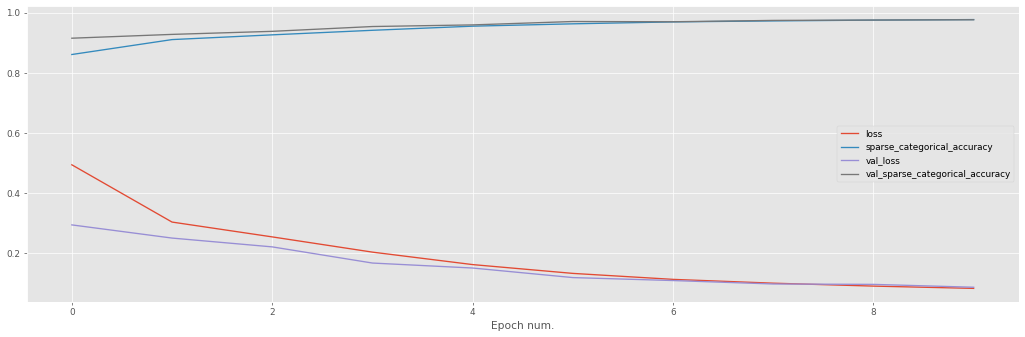

In [13]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Perce un entrenamiento bastante bueno. Evaluemos ahora el modelo.

<div style="padding:.5rem;color:white;background-color:#3c6478"><b>Ejercicio</b>. Evalúa el conjunto modelo contra el conjunto de datos de test.</div>

In [14]:
loss, acc = model.evaluate(x_test, y_test)
print(f'Loss: {loss}; Exactitud: {acc}')

313/313 [==============================] - 0s 813us/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9751
Loss: 0.08118825405836105; Exactitud: 0.9750999808311462


Una más que buena predicción en test. Parece que en producción nuestra red se comportará bastante bien

313/313 [==============================] - 0s 745us/step
[7 2 1 ... 4 5 6]


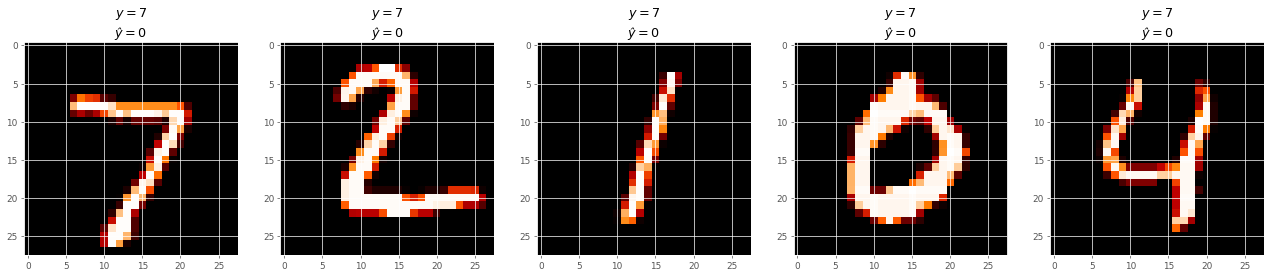

In [24]:
ŷ_test = model.predict(x_test).argmax(axis=-1)

show_examples(x_test, y_test.argmax(axis=-1), ŷ_test)

Impecable. Ahora vamos a ver qué pasaría con un modelo demasiado grande y el efecto que la regularización puede tener en este tipo de entrenamientos.

## Un problema gordo: CIFAR 100

Ya tenemos todas las bases para trabajar con redes de convolución. Vamos a aplicarlo a un problema concreto: el de [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) (DISPONIBLE EN <https://www.cs.toronto.edu/~kriz/cifar.html>.

<div style="padding:.5rem;color:white;background-color:#3c6478"><b>Ejercicio</b>. Entrena el modelo basado en redes de convolución o en perceptrones multicapa que mejoren en un $75\%$ el error en entrenamiento y que, en la medida de lo posible, generalicen bien. El conjunto se encuentra bajo el módulo <code>datasets</code>. ¡Buena suerte!</div>

## Conclusiones

A lo largo de este _notebook_ hemos abordado varios conceptos y técnicas cruciales en el ámbito del aprendizaje profundo y la clasificación de imágenes. Algunas de las conclusiones clave que podemos extraer de aquí son las siguientes:

1. **MNIST como inicio para la visión robótica**: Si bien el conjunto de datos MNIST es una introducción básica a la clasificación de imágenes, sienta las bases para técnicas más avanzadas de visión robótica. La percepción en robótica no se limita a identificar dígitos, sino que se expande a la detección de objetos, seguimiento, navegación y mucho más.
1. **Importancia del diseño adecuado del modelo**: Hemos visto que no basta con agregar capas y nodos a una red neuronal esperando mejorar automáticamente el rendimiento. Un modelo sobredimensionado puede adaptarse demasiado a los datos de entrenamiento, lo que lleva a un sobreajuste y una pobre generalización en datos no vistos. Por tanto, es esencial considerar la complejidad del modelo en función del tamaño y la naturaleza del conjunto de datos.
1. **Regularización con Dropout**: El Dropout emerge como una herramienta poderosa para combatir el sobreajuste en redes neuronales. Al desactivar aleatoriamente nodos durante el entrenamiento, esta técnica evita que la red se vuelva demasiado dependiente de cualquier nodo o característica específica, promoviendo la robustez y la generalización. Sin embargo, el grado de Dropout (la proporción de nodos desactivados) es un hiperparámetro que debe ajustarse adecuadamente, ya que un valor excesivo puede llevar a un entrenamiento ineficiente y una generalización insuficiente.
1. **Iteración en entornos dinámicos**: En robótica, los modelos de percepción deben ser probados y ajustados en ambientes dinámicos y a menudo impredecibles. Esto significa que es crucial iterar y experimentar con el modelo en situaciones del mundo real, y no solo confiar en conjuntos de datos estáticos.
1. **Exploraciones futuras en percepción robótica**: Aunque hemos sentado las bases para la percepción usando perceptrones multicapa, hay muchas técnicas y arquitecturas avanzadas específicas para la robótica, como las redes neuronales convolucionales (CNN) para la visión por computadora o las redes recurrentes (RNN) para secuencias temporales, que son esenciales para tareas como la navegación y la planificación de trayectorias.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>